# 1. 필요한 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import os
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/My Drive/231026 분석교육'

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-62-61e239d3f122>", line 1, in <cell line: 1>
    get_ipython().run_line_magic('cd', "'drive/My Drive/231026 분석교육'")
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/in

In [ ]:
import os
print(os.getcwd())

/content/drive/My Drive/231026 분석교육


In [ ]:
path = './data/시군구 단위'

# 2. 소수력 잠재 발전량 공식

소수력 에너지 부존량
𝑃(𝑊)=𝑔𝑄𝐻𝜂𝜌∆t

𝑔 = 중력가속도 9.8(𝑚/𝑠^2)

𝑄 = 유량 (𝑚^3/𝑠)

𝐻 = 낙차(𝑚)

𝜂 = 효율 0.7

𝜌 = 물의 밀도 1000(𝑘𝑔/𝑚^3)

∆t = 시간(1일 = 24, 1년 = 24 * 365)

In [ ]:
# PW = 9.8 * FW * 1.5 * 0.7 * 1000 * 24

# 3. 데이터 불러오기

## 3-1 소수력 잠재 발전 가능량 데이터 합치기

In [ ]:
total = []
path_dir = './data/시군구단위' # 시군구단위 폴더 내 파일 경로
files = os.listdir(path_dir) # 폴더 내 파일을 리스트로 반환

# 소수력 잠재 발전 가능량 데이터를 2022년 01월 ~ 12월까지 합치는 코드
for file in files:
    data = pd.read_csv(path_dir + '/' + file) # './데이터/시군구단위/파일명
    total.append(data[data['SGG_CD'] == 42150]) # 강릉시 시군구 코드

small = pd.concat(total)

small = small[['YMD', 'FW']] # 분석에 필요한 컬럼만 가져오기
small = small.reset_index(drop=True)

small['FW'] = [0 if x == -999.0 else x for x in small['FW']] # -999.0는 0으로 변경
small

,YMD,FW
0,2022-02-01,0.00
1,2022-02-02,0.00
2,2022-02-03,0.00
3,2022-02-04,0.00
4,2022-02-05,0.00
...,...,...
360,2022-11-26,0.46
361,2022-11-27,0.50
362,2022-11-28,0.63
363,2022-11-29,1.96


## 3-2 해당 시군구의 ASOS 기상 자료 불러오기

In [ ]:
weather = pd.read_csv('./강원도 강릉시.csv')
weather['일강수량(mm)'] = weather['일강수량(mm)'].fillna(0) # 일강수량이 NaN인 경우 0으로 채우기
weather = weather[['일시', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '평균 풍속(m/s)', '평균 상대습도(%)']]
weather.columns = ['YMD', 'TMIN', 'TMAX', 'PCP', 'WDSP', 'RLTV_HM']
weather

,YMD,TMIN,TMAX,PCP,WDSP,RLTV_HM
0,2022-01-01,-5.7,6.4,0.0,2.5,34.0
1,2022-01-02,0.0,8.7,0.0,3.3,41.3
2,2022-01-03,-1.2,5.9,0.0,3.0,35.4
3,2022-01-04,-2.1,5.9,0.0,1.7,46.9
4,2022-01-05,-3.3,5.7,0.0,2.1,60.9
...,...,...,...,...,...,...
360,2022-12-27,-1.5,10.6,0.0,3.2,35.4
361,2022-12-28,-2.1,5.2,0.0,3.9,40.9
362,2022-12-29,-3.9,6.9,0.0,2.7,36.5
363,2022-12-30,-1.0,7.9,0.0,2.9,43.8


## 3-3 소수력 잠재 발전량 데이터와 기상 데이터 합치기 (YMD 컬럼을 기준으로 Inner 조인)

In [ ]:
data = pd.merge(left=small, right=weather, on='YMD', how='inner')
data.index = data['YMD']
data = data.drop(columns=['YMD'])
data

,FW,TMIN,TMAX,PCP,WDSP,RLTV_HM
YMD,,,,,,
2022-02-01,0.00,-0.6,5.8,0.0,3.2,46.1
2022-02-02,0.00,-1.6,5.5,0.0,4.0,37.8
2022-02-03,0.00,-2.9,6.5,0.0,3.1,32.6
2022-02-04,0.00,-4.4,4.1,0.0,3.4,30.4
2022-02-05,0.00,-7.3,1.6,0.0,4.0,32.8
...,...,...,...,...,...,...
2022-11-26,0.46,6.9,17.0,0.0,3.6,30.4
2022-11-27,0.50,4.5,15.0,0.0,1.9,38.8
2022-11-28,0.63,4.7,15.9,3.4,1.0,66.8


## (추가) KNN IMPUTER를 이용한 데이터 보간

In [ ]:
# from sklearn.impute import KNNImputer
# imputer=KNNImputer(n_neighbors=5)

# cols = data.columns
# filled_data=imputer.fit_transform(data)
# filled_data = pd.DataFrame(data=filled_data, columns=cols)
# filled_data.index = pd.to_datetime(data.index)
# filled_data

In [ ]:
filled_data = data.copy()
filled_data.index = pd.to_datetime(data.index)

## 3-5 소수력 잠재 발전량 계산

In [ ]:
filled_data['PW(kW)'] = (9.8 * filled_data['FW'] * 1.5 * 0.7 * 1000 * 24) / 1000
filled_data

,FW,TMIN,TMAX,PCP,WDSP,RLTV_HM,PW(kW)
YMD,,,,,,,
2022-02-01,0.00,-0.6,5.8,0.0,3.2,46.1,0.0000
2022-02-02,0.00,-1.6,5.5,0.0,4.0,37.8,0.0000
2022-02-03,0.00,-2.9,6.5,0.0,3.1,32.6,0.0000
2022-02-04,0.00,-4.4,4.1,0.0,3.4,30.4,0.0000
2022-02-05,0.00,-7.3,1.6,0.0,4.0,32.8,0.0000
...,...,...,...,...,...,...,...
2022-11-26,0.46,6.9,17.0,0.0,3.6,30.4,113.6016
2022-11-27,0.50,4.5,15.0,0.0,1.9,38.8,123.4800
2022-11-28,0.63,4.7,15.9,3.4,1.0,66.8,155.5848


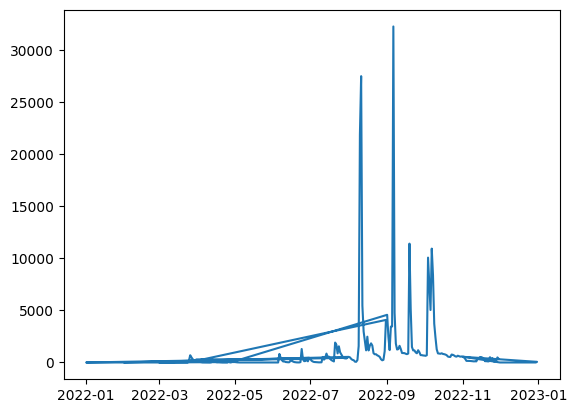

In [ ]:
plt.plot(filled_data['PW(kW)'])
plt.show()

## 3-6 이상치 제거

In [ ]:
del_list = filled_data.sort_values(by='PW(kW)', ascending=False)[:20].index
filled_data = filled_data.drop(index= del_list)
filled_data

,FW,TMIN,TMAX,PCP,WDSP,RLTV_HM,PW(kW)
YMD,,,,,,,
2022-02-01,0.00,-0.6,5.8,0.0,3.2,46.1,0.0000
2022-02-02,0.00,-1.6,5.5,0.0,4.0,37.8,0.0000
2022-02-03,0.00,-2.9,6.5,0.0,3.1,32.6,0.0000
2022-02-04,0.00,-4.4,4.1,0.0,3.4,30.4,0.0000
2022-02-05,0.00,-7.3,1.6,0.0,4.0,32.8,0.0000
...,...,...,...,...,...,...,...
2022-11-26,0.46,6.9,17.0,0.0,3.6,30.4,113.6016
2022-11-27,0.50,4.5,15.0,0.0,1.9,38.8,123.4800
2022-11-28,0.63,4.7,15.9,3.4,1.0,66.8,155.5848


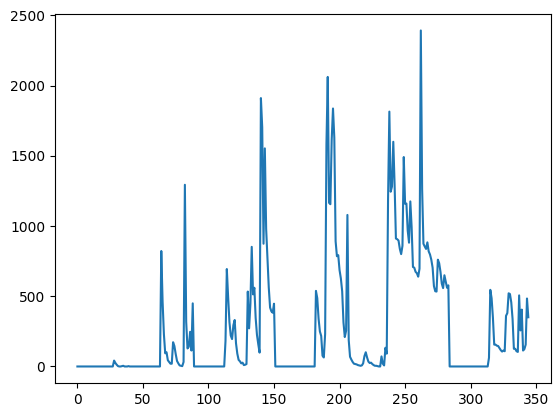

In [ ]:
plt.plot(filled_data['PW(kW)'].values)
plt.show()

# 4. 대리변수 추가

## 4-1 이동평균 변수 추가

In [ ]:
col_list = ['TMIN', 'TMAX', 'PCP', 'WDSP', 'RLTV_HM']

for MA in [3, 5, 7]:
    for col in col_list:
        filled_data[f'{col}_MA_{MA}'] = filled_data[col].rolling(window=MA).mean()

filled_data = filled_data.dropna() # MA 계산으로 인한 NaN 제거

In [ ]:
filled_data

,FW,TMIN,TMAX,PCP,WDSP,RLTV_HM,PW(kW),TMIN_MA_3,TMAX_MA_3,PCP_MA_3,WDSP_MA_3,RLTV_HM_MA_3,TMIN_MA_5,TMAX_MA_5,PCP_MA_5,WDSP_MA_5,RLTV_HM_MA_5,TMIN_MA_7,TMAX_MA_7,PCP_MA_7,WDSP_MA_7,RLTV_HM_MA_7
YMD,,,,,,,,,,,,,,,,,,,,,,
2022-02-07,0.00,-3.8,4.3,0.0,1.9,36.8,0.0000,-5.733333,3.600000,0.000000,2.866667,33.200000,-4.90,4.28,0.00,3.02,32.52,-3.814286,4.671429,0.000000,3.185714,35.214286
2022-02-08,0.00,-2.2,7.2,0.0,1.7,39.5,0.0000,-4.033333,5.466667,0.000000,2.100000,35.433333,-4.76,4.42,0.00,2.74,33.90,-4.042857,4.871429,0.000000,2.971429,34.271429
2022-02-09,0.00,-2.1,9.8,0.0,2.5,45.3,0.0000,-2.700000,7.100000,0.000000,2.033333,40.533333,-4.30,5.56,0.00,2.56,36.88,-4.114286,5.485714,0.000000,2.757143,35.342857
2022-02-10,0.00,0.0,8.6,0.0,2.4,50.5,0.0000,-1.433333,8.533333,0.000000,2.200000,45.100000,-2.84,6.96,0.00,2.24,40.42,-3.700000,5.785714,0.000000,2.657143,37.900000
2022-02-11,0.00,-0.3,11.7,0.0,2.0,39.1,0.0000,-0.800000,10.033333,0.000000,2.300000,44.966667,-1.68,8.32,0.00,2.10,42.24,-3.114286,6.871429,0.000000,2.457143,39.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-26,0.46,6.9,17.0,0.0,3.6,30.4,113.6016,8.033333,18.600000,0.000000,3.266667,43.800000,8.46,17.36,4.76,2.58,56.90,8.614286,18.314286,3.400000,2.328571,58.314286
2022-11-27,0.50,4.5,15.0,0.0,1.9,38.8,123.4800,7.000000,17.866667,0.000000,3.233333,35.266667,7.58,16.96,3.92,2.64,51.26,8.014286,17.500000,3.400000,2.400000,54.385714
2022-11-28,0.63,4.7,15.9,3.4,1.0,66.8,155.5848,5.366667,15.966667,1.133333,2.166667,45.333333,6.66,17.34,0.68,2.54,47.40,7.357143,16.814286,3.885714,2.257143,55.728571


# 5. 상관관계 분석

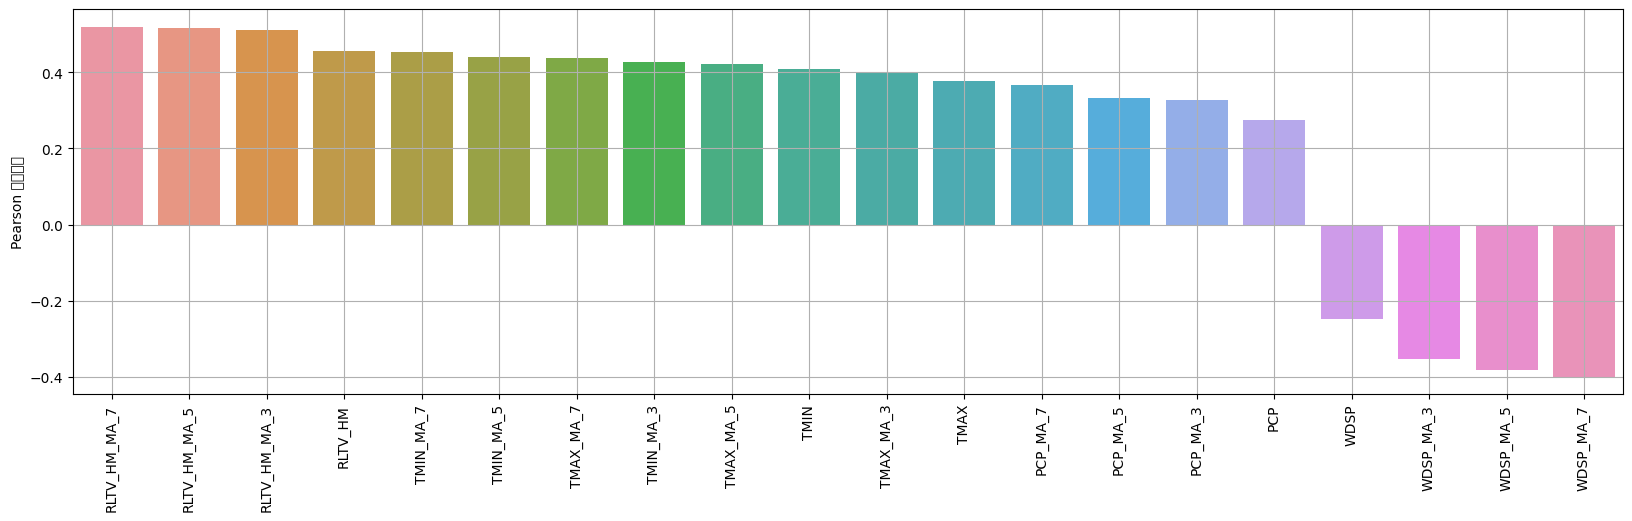

In [ ]:
plt.figure(figsize=(20, 5))
sns.barplot(x=np.array(filled_data.corr()[['PW(kW)']].sort_values(by=['PW(kW)'], ascending=False).index[2:]).reshape(-1, ),
            y=np.array(filled_data.corr()[['PW(kW)']].sort_values(by=['PW(kW)'], ascending=False).values[2:]).reshape(-1, ))
plt.xticks(rotation=90)
plt.grid()
plt.ylabel('Pearson 상관계수')
plt.show()

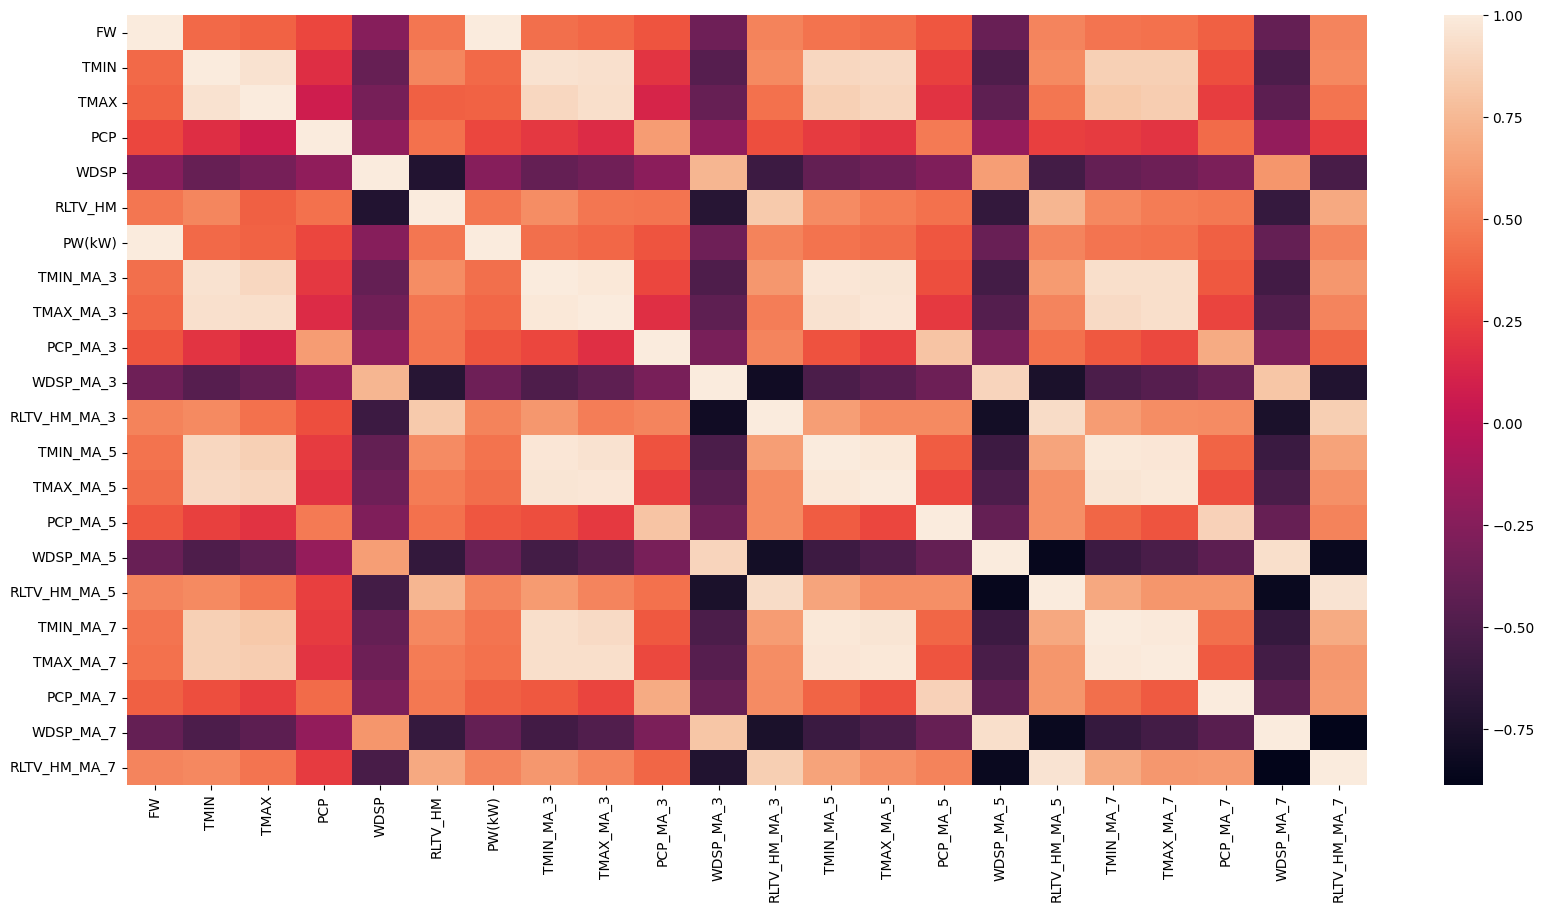

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(filled_data.corr())
plt.show()

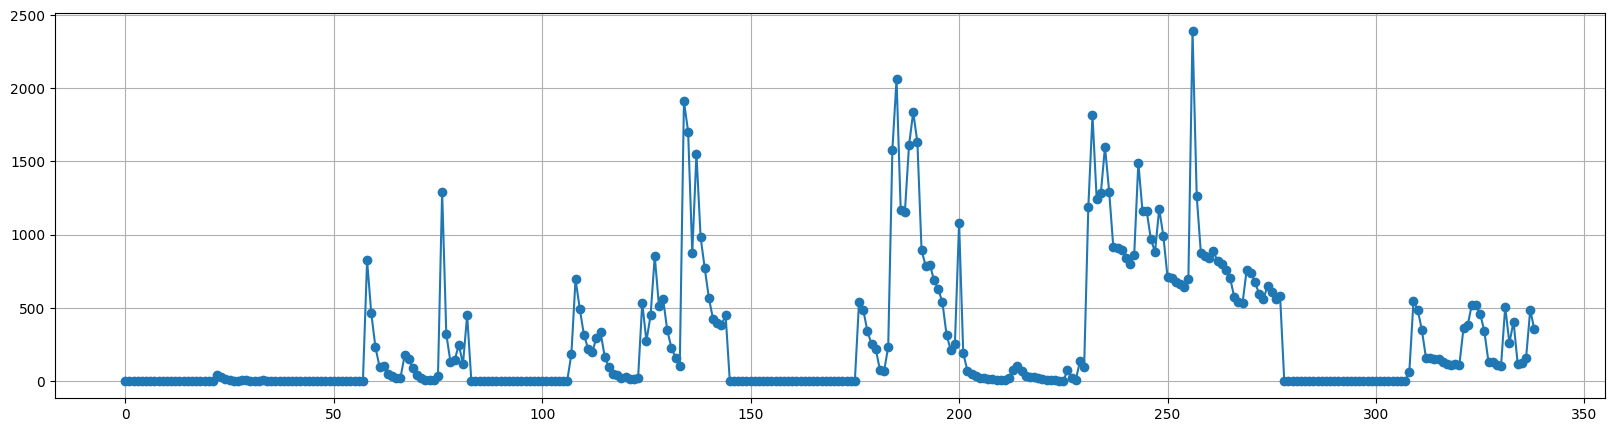

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(filled_data['PW(kW)'].values, 'o-')
plt.grid()
plt.show()

# 6. 시계열 분석

## 6-1 시계열 분해(Seasonal Decomposition)

In [ ]:
filled_data = filled_data.asfreq(freq='d') # 데이터의 주기 설정

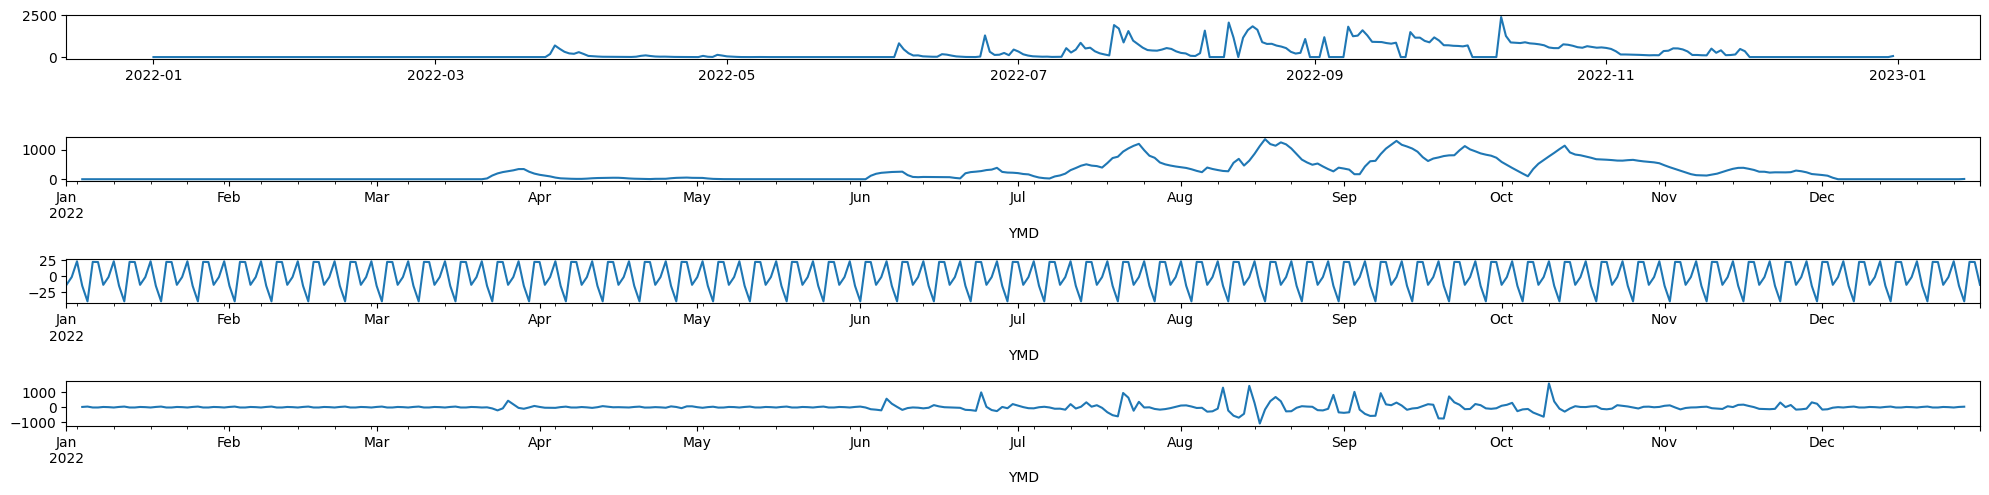

In [ ]:
import statsmodels as sm

result = sm.tsa.seasonal.seasonal_decompose(x=filled_data['PW(kW)'].fillna(0), model='addictive') # 데이터에 결측치가 있으면 안됩니다.

# 분해 결과를 시각화
fig, ax = plt.subplots(4, 1, figsize=(20, 5))

ax[0].plot(filled_data['PW(kW)'].fillna(0)) # 데이터 : 데이터 = 추세 + 계절성 + 잔차
result.trend.plot(ax=ax[1]) # 데이터의 추세
result.seasonal.plot(ax=ax[2]) # 데이터의 계절성
result.resid.plot(ax=ax[3]) # 데이터의 잔차

plt.tight_layout()
plt.show()

# 6. 전진 선택법을 이용한 변수 선택

In [ ]:
dataset = filled_data.dropna().copy()
dataset = dataset.drop(columns=['FW'])

target = 'PW(kW)'
y = dataset[target] # 종속변수 선택
X = dataset.loc[:, dataset.columns !=target] #종속변수를 제외한 나머지 독립변수 선택
X = X.loc[:, X.columns !=target]

In [ ]:
import statsmodels.api as sm

In [ ]:
# 전진 선택법

def forward(df, y, significance_level=0.05):
    selected_variables = [] # 선택된 변수를 저장할 리스트 선언
    sl_enter = significance_level

    sv_per_step = []
    adjusted_r_squared = []
    steps = []
    step = 0
    len_selected_variables = 0

    while len_selected_variables < len(df.columns):
        remaining_vars = list(set(df.columns) - set(selected_variables)) # 전체 컬럼에서 선택된 변수 제거
        pval = pd.Series(index=remaining_vars) # 각 컬럼의 p-value를 저장할 pval Series 생성

        # 컬럼을 1개씩 가져와서 selected_variables에 추가하고, 해당 컬럼의 p-value값을 pval에 저장
        for col in remaining_vars:
            X = df[selected_variables + [col]] # selected_variables에 remaining_vars에 있는 컬럼 1개 추가
            X = sm.add_constant(X) # X에 모든 행의 값이 1인 상수항 컬럼 추가
            model = sm.OLS(y, X).fit()
            pval[col] = model.pvalues[col]

        min_pval = pval.min() # pval에 저장된 p-value중 최소값 저장

        selected_variables.append(pval.idxmin())

        step += 1
        steps.append(step)
        model = sm.OLS(y, sm.add_constant(df[selected_variables]))
        adj_r_squared = model.fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())

        len_selected_variables = len(selected_variables)


    return model, steps, sv_per_step, adjusted_r_squared

In [ ]:
model, steps, sv_per_step, adjusted_r_squared = forward(X,y)

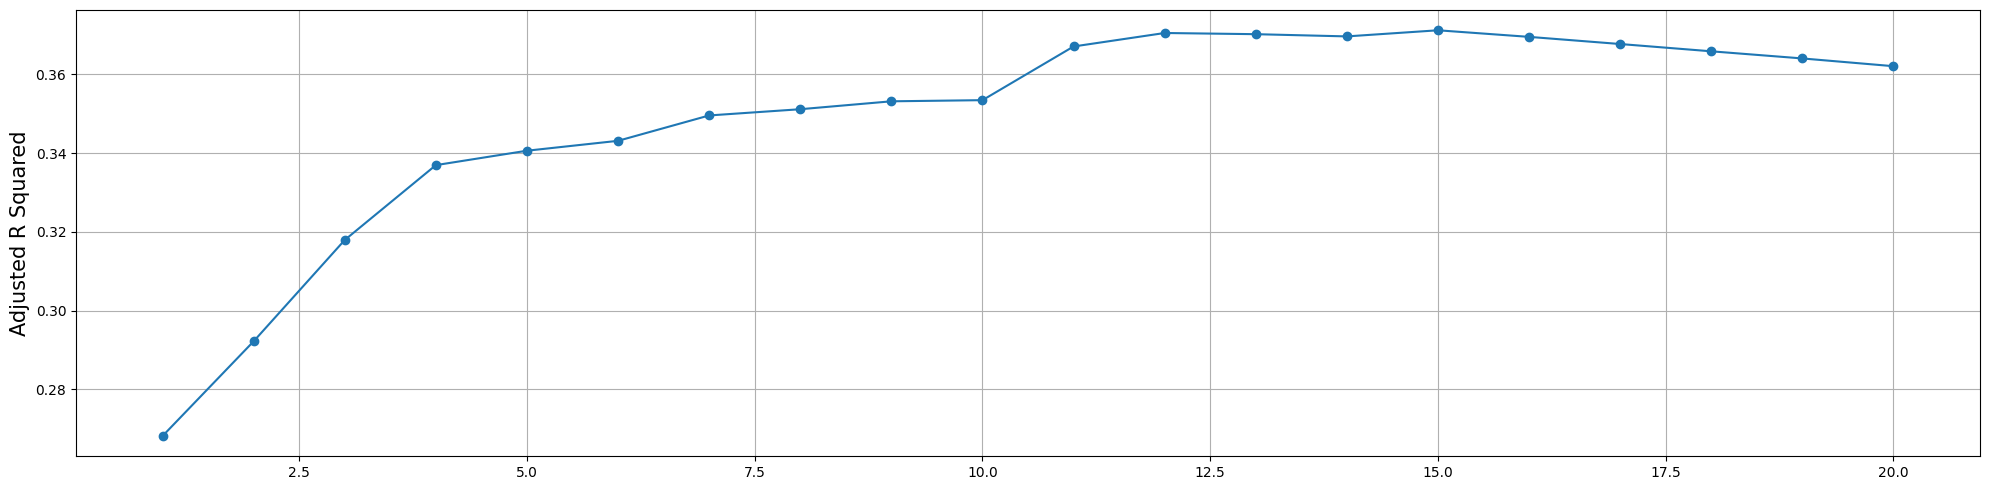

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.set_facecolor('white')

font_size = 15
# plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')

plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# R2-score값이 최대인 step 찾기

max_step = adjusted_r_squared.index(max(adjusted_r_squared)) + 1
max_r2 = max(adjusted_r_squared)
forward_values = sv_per_step[adjusted_r_squared.index(max(adjusted_r_squared))]

print(f'selected values : {forward_values}')
print(f'step : {max_step}, {max_r2}')

selected values : ['RLTV_HM_MA_7', 'PCP', 'TMAX', 'WDSP_MA_7', 'RLTV_HM_MA_3', 'TMIN_MA_3', 'TMAX_MA_3', 'RLTV_HM_MA_5', 'WDSP_MA_3', 'TMAX_MA_7', 'TMIN_MA_7', 'TMIN_MA_5', 'PCP_MA_3', 'RLTV_HM', 'WDSP']
step : 15, 0.3712107327036419


In [ ]:
PCP_list = [x for x in forward_values if 'PCP' in x]
TMAX_list = [x for x in forward_values if 'TMAX' in x]
TMIN_list = [x for x in forward_values if 'TMIN' in x]
RLTV_HM_list = [x for x in forward_values if 'RLTV_HM' in x]
WDSP_list = [x for x in forward_values if 'WDSP' in x]

total_list = [PCP_list] + [TMAX_list] + [TMIN_list] + [RLTV_HM_list] + [WDSP_list]
total_list

[['PCP', 'PCP_MA_3'],
 ['TMAX', 'TMAX_MA_3', 'TMAX_MA_7'],
 ['TMIN_MA_3', 'TMIN_MA_7', 'TMIN_MA_5'],
 ['RLTV_HM_MA_7', 'RLTV_HM_MA_3', 'RLTV_HM_MA_5', 'RLTV_HM'],
 ['WDSP_MA_7', 'WDSP_MA_3', 'WDSP']]

In [ ]:
selected_list = []
for cols_list in total_list:
    if len(cols_list) == 0:
        continue
    selected_list.append(filled_data[cols_list + ['PW(kW)']].corr()[['PW(kW)']].sort_values(by=['PW(kW)'], ascending=False).index[1])

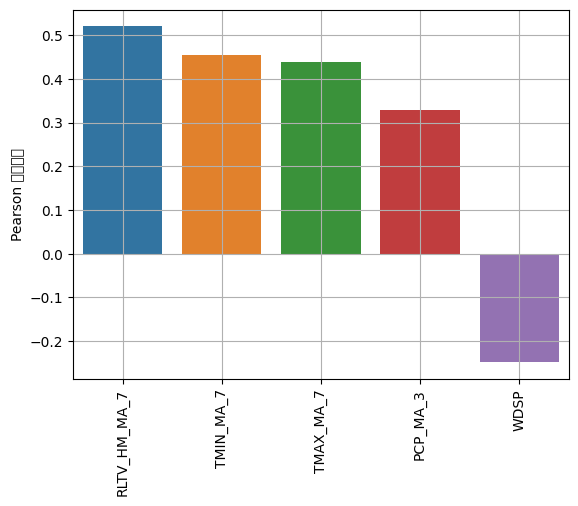

In [ ]:
filled_data = filled_data[selected_list + ['PW(kW)']]
sns.barplot(x=np.array(filled_data.corr()[['PW(kW)']].sort_values(by=['PW(kW)'], ascending=False).index[1:]).reshape(-1, ),
            y=np.array(filled_data.corr()[['PW(kW)']].sort_values(by=['PW(kW)'], ascending=False).values[1:]).reshape(-1, ))
plt.xticks(rotation=90)
plt.grid()
plt.ylabel('Pearson 상관계수')
plt.show()

# 7. 머신러닝 모델 학습

## 7-1 필요한 라이브러리 불러오기

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import sklearn

## 7-2 독립변수, 종속변수 설정

In [ ]:
filled_data = filled_data.dropna()

X = filled_data.drop(columns=['PW(kW)'])
y = filled_data[['PW(kW)']]

## 7-3 데이터 정규화

In [ ]:
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

scaler.fit(X)
y_scaler.fit(y)

X_scaled = scaler.transform(X)
y_scaled = y_scaler.transform(y)

## 7-4 Train, Test 분할

In [ ]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

## 7-5 하이퍼파라미터 튜닝 (그리드 서치)

### 7-5-1 Support Vector Machine

![image.png](attachment:29fa7fe9-896a-44fe-b51a-6d0f4ef070f0.png)

In [ ]:
param_grid = {'C' : [0.5, 1, 5, 10, 25, 50, 75, 110, 100, 125], # Cost이며, 낮을수록 에러를 많이 허용 -> 과소적합
              'kernel' : ['linear', 'rbf'], # 커널함수
              'gamma' : [0.1, 0.5, 0.9, 1.0, 1.1]} # 모델이 생성하는 경계가 복잡해지는 정도. 결정 경계의 곡률을 조정

model = GridSearchCV(estimator=SVR(),
                     param_grid=param_grid,
                     cv=5,
                     scoring=sklearn.metrics.mean_squared_error,
                     n_jobs=-1)

model.fit(x_train_scaled, y_train_scaled)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.5, 1, 5, 10, 25, 50, 75, 110, 100, 125],
                         'gamma': [0.1, 0.5, 0.9, 1.0, 1.1],
                         'kernel': ['linear', 'rbf']},
             scoring=<function mean_squared_error at 0x7d9d3b98b010>)

### 7-5-2 Random Forest

![image.png](attachment:33aa967b-abb1-4b1a-a808-a3f6be3d6429.png)

In [ ]:
#GridSearchCV
param_grid = {'n_estimators' : [100, 200, 300], # 생성할 트리 수
              'max_depth' : [3, 5, 7, 9, 10], # 트리의 최대 깊이
              'min_samples_leaf' : [1, 5, 10, 15], # leaf가 되기 위한 최소 샘플 데이터 수
              'min_samples_split' : [2, 5, 10, 15]} # 노드를 분할하기 위한 최소 샘플 데이터 수

model = GridSearchCV(estimator=RandomForestRegressor(),
                     param_grid=param_grid,
                     scoring=sklearn.metrics.mean_squared_error,
                     n_jobs=-1)

# model = RandomForestRegressor()
model.fit(x_train_scaled, y_train_scaled)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 10],
                         'min_samples_leaf': [1, 5, 10, 15],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring=<function mean_squared_error at 0x000001D6D8DD8E50>)

## 7-5 선정된 하이퍼 파라미터 확인

In [ ]:
print(model.best_params_)

{'C': 0.5, 'gamma': 0.1, 'kernel': 'linear'}


## 7-6 예측 결과 확인

### 7-6-1 Train

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(x_train_scaled)
y_pred = [ 0 if x < 0.0 else x for x in y_pred]
y_pred = np.array(y_pred).reshape(-1, 1)

print('MSE : ', mean_squared_error(y_train_scaled, y_pred))
print('MAE : ', mean_absolute_error(y_train_scaled, y_pred))
print('R2 : ', r2_score(y_train_scaled, y_pred))

MSE :  0.02761876603951717
MAE :  0.11527660177359826
R2 :  0.2940087299079843


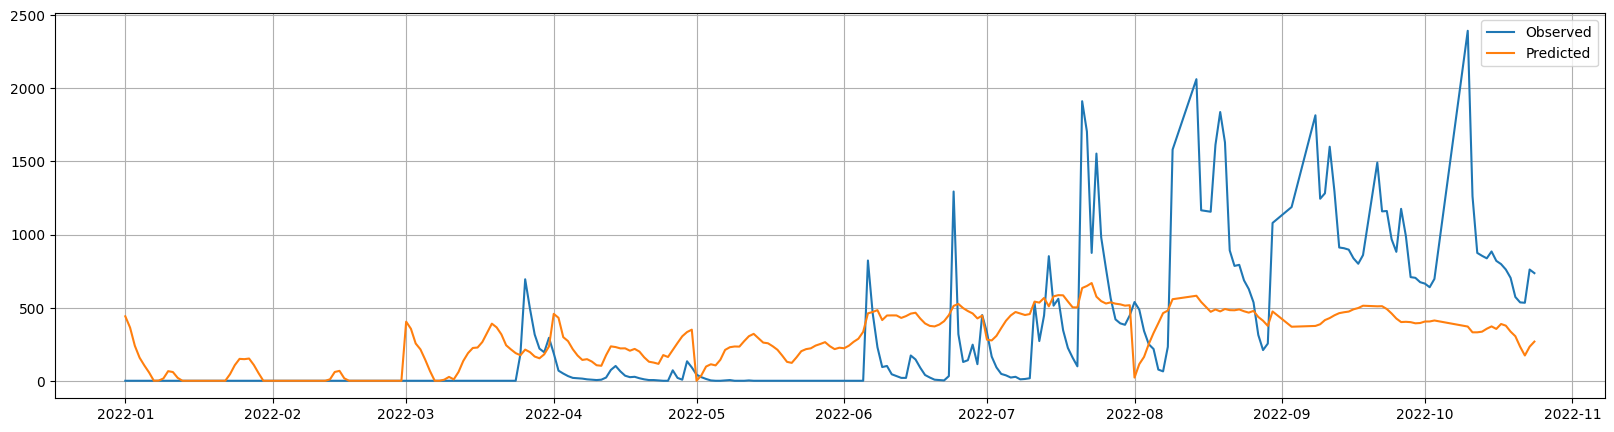

In [ ]:
plt.figure(figsize=(20, 5))

train_len = filled_data.index[:len(y_train_scaled)]

plt.plot(train_len, y_scaler.inverse_transform(y_train_scaled), label='Observed')
plt.plot(train_len, y_scaler.inverse_transform(y_pred), label='Predicted')
plt.legend()
plt.grid()
plt.show()

### 7-6-2 Test

In [ ]:
y_pred = model.predict(x_test_scaled)
y_pred = [ 0 if x < 0.0 else x for x in y_pred]
y_pred = np.array(y_pred).reshape(-1, 1)

print('MSE : ', mean_squared_error(y_test_scaled, y_pred))
print('MAE : ', mean_absolute_error(y_test_scaled, y_pred))
print('R2 : ', r2_score(y_test_scaled, y_pred))

MSE :  0.0046345709370050935
MAE :  0.04319929626082511
R2 :  0.4429623808550237


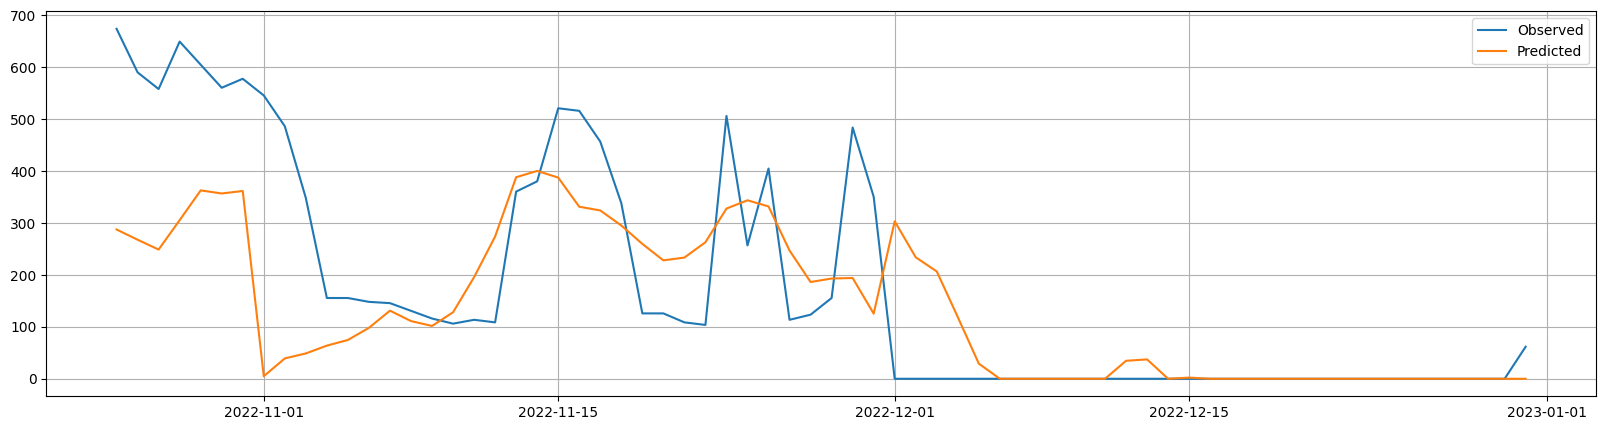

In [ ]:
plt.figure(figsize=(20, 5))

test_len = filled_data.index[-len(y_test_scaled):]
plt.plot(test_len, y_scaler.inverse_transform(y_test_scaled), label='Observed')
plt.plot(test_len, y_scaler.inverse_transform(y_pred), label='Predicted')
plt.legend()
plt.grid()
plt.show()

# (추가) SSP 기후변화 시나리오를 이용한 미래 소수력 잠재 발전량 예측

In [ ]:
ssp_data = pd.read_csv('./SSP 기후변화 시나리오/asos105_SQM_CanESM5_ssp126.csv')

ssp_data['year'] = [str(x) for x in ssp_data['year']]

# 자리수가 2자리가 아닌경우 0을 붙이기
ssp_data['mon'] = ['0' + str(x) if len(str(x)) == 1 else str(x) for x in ssp_data['mon']]
ssp_data['day'] = ['0' + str(x) if len(str(x)) == 1 else str(x) for x in ssp_data['day']]

# YMD 형식으로 바꾸기
ssp_data['YMD'] = ssp_data['year'] + '-' + ssp_data['mon'] + '-' + ssp_data['day']
ssp_data['YMD'] = pd.to_datetime(ssp_data['YMD'])
ssp_data.index = ssp_data['YMD']
ssp_data = ssp_data.drop(columns=['YMD'])

# 필요없는 컬럼 제거
ssp_data = ssp_data.drop(columns=['year', 'mon', 'day', 'rsds'])

ssp_data.columns = ['PCP', 'TMAX', 'TMIN', 'WDSP', 'RLTV_HM']
ssp_data['RLTV_HM'] = ssp_data['RLTV_HM'] * 100
ssp_data = ssp_data.loc[ssp_data.index >= '2030-01-01', :]
ssp_data

,PCP,TMAX,TMIN,WDSP,RLTV_HM
YMD,,,,,
2030-01-01,0.000000,9.697580,1.730809,2.300415,36.722553
2030-01-02,4.596948,10.621242,2.217033,4.933855,40.371040
2030-01-03,0.000000,8.239109,0.596302,5.366137,35.266642
2030-01-04,0.000000,6.693354,0.255099,1.993540,43.840000
2030-01-05,0.100000,8.516872,-3.487122,3.001724,53.974000
...,...,...,...,...,...
2100-12-27,0.000000,5.121425,0.300000,3.167962,50.720000
2100-12-28,0.000000,7.569254,-0.163080,1.108586,50.907405
2100-12-29,0.000000,9.081999,2.497302,2.907266,31.151992


In [ ]:
col_list = ['TMIN', 'TMAX', 'PCP', 'WDSP', 'RLTV_HM']

for MA in [3, 5, 7]:
    for col in col_list:
        ssp_data[f'{col}_MA_{MA}'] = ssp_data[col].rolling(window=MA).mean()

ssp_data = ssp_data.dropna()

ssp_data = ssp_data[selected_list]

In [ ]:
ssp_data_scaled = scaler.transform(ssp_data)

y_pred = model.predict(ssp_data_scaled)
y_pred = [ 0 if x < 0.0 else x for x in y_pred]
y_pred = np.array(y_pred).reshape(-1, 1)

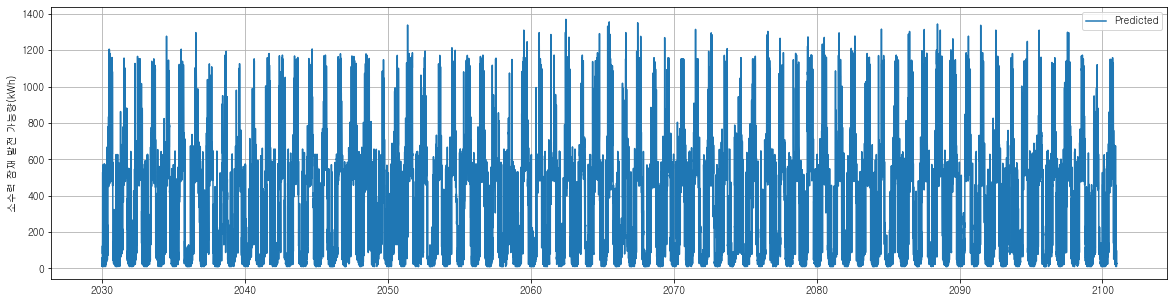

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(ssp_data.index, y_scaler.inverse_transform(y_pred), label='Predicted')
plt.legend()
plt.ylabel('소수력 잠재 발전 가능량(kWh)')
plt.grid()
plt.show()